<a href="https://colab.research.google.com/github/avionerman/machine_learning_2025/blob/main/Exercise_9_PCA_LDA_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Profiling

In [40]:
!pip install ydata-profiling --quiet

import pandas as pd
from ydata_profiling import ProfileReport
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/bankloan.csv")

print("Shape:", df.shape)
print("Missing values (top 10):\n", df.isnull().sum().sort_values(ascending=False).head(10))

profile = ProfileReport(df, title="Risk Analysis - Profiling Report", explorative=True)

profile.to_file("bankloan_profiling_report.html")

# files.download("bankloan_profiling_report.html")


Shape: (212999, 53)
Missing values (top 10):
 Unnamed: 50                    212999
Row ID                         212631
dti_joint                      212560
annual_inc_joint               212558
36months                       212488
60months                       212488
mths_since_last_major_derog    150634
mths_since_last_delinq         103371
emp_title                       12790
emp_length                      12767
dtype: int64


# Step 2: Data filtering

Steps that will be followed in Step 2:

*   In this section I want to **summarize** my stats for the **loan_amnt feature** (*mean, max, min*)
*   Then I want to **drop the unneded features** (IDs, columns with many missing values, irrelevant attributes, etc.).
*   Thirdly, I may need to **apply an imputer** to handle the missing data (if too many and the feature is not so relevant, will drop them completely).
*   After, will use **encoding to the target column** (*if grade is A, B1 and B2 then the target will be marked as 1*).
*   Lastly, **explore** the **loan amount ranges** likely to be accepeted (i.e., *if the loan amount is between 50 and 55 thousands is more likely to be approved or not?*).

Loan Amount Stats: Mean: 15257.97, Max: 35000.00, Min: 1000.00





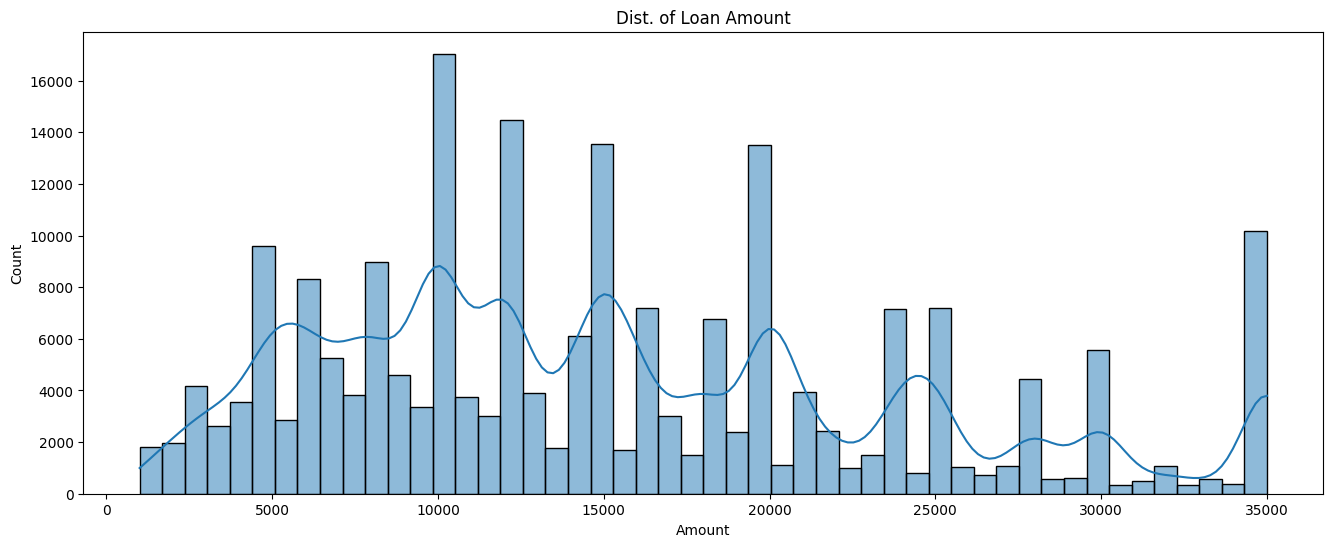

In [41]:
print(f"Loan Amount Stats: Mean: {df['loan_amnt'].mean():.2f}, Max: {df['loan_amnt'].max():.2f}, Min: {df['loan_amnt'].min():.2f}")

print("\n\n")

plt.figure(figsize=(16,6))
sns.histplot(df['loan_amnt'], bins=50, kde=True)
plt.title('Dist. of Loan Amount')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()


After analyzing the dataset shape and the HTML report from the Step 1, I figured out that the following features are not needed:
<br>

1. id (ID)
2. member_id (ID)
3. emp_title (just text)
4. title (not helping my purpose)
5. zip_code (not helping my purpose)
6. addr_state (not much context)
7. grade (leak)
8. sub_grade (leak)
9. issue_id (data post loan doesn't help me)
10. pymnt_plan (meta, not helping my purpose)
11. earliest_cr_line (hard to handle string value)
12. initial_list_status (listing type - no value)
13. out_prncp (data post loan doesn't help me)
14. out_prncp_inv (data post loan doesn't help me)
15. total_pymnt (result)
16. total_pymnt_inv (result)
17. recoveries (result)
18. collection_recovery_free (result)
19. last_pymnt_d (data post loan doesn't help me)
20. last_pymnt_amnt (data post loan doesn't help me)
21. next_pymnt_d (data post loan doesn't help me)
22. last_credit_pull_d (data post loan doesn't help me)
23. application_type (too custom, doesn't help)

In [42]:

print("\n\n >>> [1] DROPPING UNNEEDED FEATURES ...")

# drop unneeded features (based on my personal analysis/filtering)
dropped_cols = [
    'id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'addr_state',
    'emp_title', 'grade',
    'issue_d', 'earliest_cr_line', 'initial_list_status', 'next_pymnt_d',
    'last_pymnt_d', 'last_credit_pull_d', 'last_pymnt_amnt',
    'recoveries', 'collection_recovery_fee',
    'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
    'pymnt_plan', 'policy_code', 'application_type'
]

df = df.drop(columns=[col for col in dropped_cols if col in df.columns])
# print(f"Features post dropping: {df.shape[1]}")


print("\n\n >>> [2] FILLING EMPTY NUMERICAL & CATEGORICAL CELLS ...")

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# adding empty numerical cols with the mean of the column set
for col in numerical_cols:
  df[col] = df[col].fillna(df[col].mean())

# adding empty categorical cols using mode() which means:
# if "x" found as max (most appeared obj), then will fill the empty cells with that obj
for col in categorical_cols:
  df[col] = df[col].fillna(df[col].mode()[0])


print("\n\n >>> [3] CALCULATING THE TARGET ...")

# at this step I realized that I need the sub_grade feature to define the target
# though I dropped that feature in the first step of this code block
# that said, I took it back, will create my target and then I will remove it again :)



if 'sub_grade' in df.columns:
  df["target"] = df["sub_grade"].isin(["A", "B1", "B2"]).astype(int)
  print(df["target"].value_counts())
  # now I will exclude the sub_grade feature
  df = df.drop(columns=["sub_grade"])
else:
  print("\n\nYou've already excluded the sub_grade feature.")


print("\n\n >>> [4] DEFINE ACCEPTED LOAN RANGES ...")

# practically I'm creating bins with the given boundaries
# and by setting right=False I am not allowing the pd.cut() to overlap the boundaries
df['loan_amnt_bin'] = pd.cut(
    df['loan_amnt'],
    bins=[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000],
    right=False
)

accepted_range = df.groupby('loan_amnt_bin', observed=False)['target'].mean()
valid_ranges = accepted_range[accepted_range >= 0.15]

if valid_ranges.empty:
    print("\nNo range found for your given ratio of 15%\n")
else:
    valid_ranges.plot(kind='bar', figsize=(16,6), title='Accepted Loan ranges')
    plt.ylabel("Accepted %")
    plt.xlabel("Loan Amount Range")
    plt.grid()
    plt.show()


# make the loan amount bins from float to string so I can parse them in the RobSc step
df['loan_amnt_bin'] = df['loan_amnt_bin'].astype(str)



 >>> [1] DROPPING UNNEEDED FEATURES ...


 >>> [2] FILLING EMPTY NUMERICAL & CATEGORICAL CELLS ...


 >>> [3] CALCULATING THE TARGET ...
target
0    188581
1     24418
Name: count, dtype: int64


 >>> [4] DEFINE ACCEPTED LOAN RANGES ...

No range found for your given ratio of 15%



# Step 3: Classification preparation & execution



 >>> [1] ONE-HOT ENCODING ENABLEMENT ...

 Post encoding you have 66 columns


 >>> [2] SEPARATING TARGET FROM THE REST ...

Found NaN, will drop them

Features shape: (212999, 64), Target shape: (212999,)


 >>> [3] NORMALIZING USING ROBUSTSCALER ...


 Your features normalized using the RobustScaler


 >>> [4] PREPARE THE DATA FOR THE RF CLASSIFIER ...
(63900, 64)


 Training set prepared accordingly


 >>> [5] TRAIN THE RF CLASSIFIER ...


 RF classifier has been trained


 >>> [6] EVALUATE CLASSIFIER'S PERFORMANCE ...


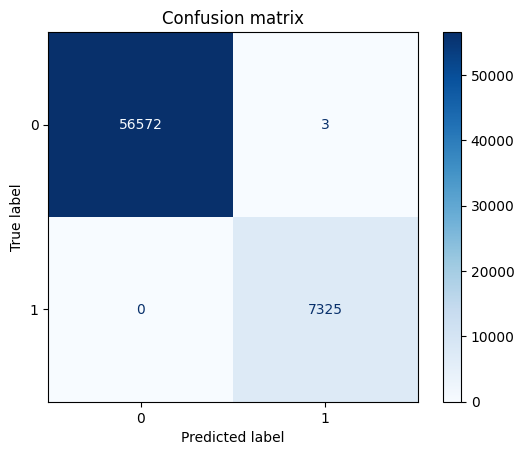



               precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000     56575
           1     0.9996    1.0000    0.9998      7325

    accuracy                         1.0000     63900
   macro avg     0.9998    1.0000    0.9999     63900
weighted avg     1.0000    1.0000    1.0000     63900



In [43]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


print("\n\n >>> [1] ONE-HOT ENCODING ENABLEMENT ...")

updated_categorical_cols = [col for col in categorical_cols if col in df.columns]

# transform categorical vars to binary [0,1]
# drop_first=True helps me to avoid the so called
# "dummy variable trap": [001, 010, 100] - diagonical (singular under the reg. matrix)
# adding loan_amnt_bin since needs to be one-hot encoded
df = pd.get_dummies(df, columns=updated_categorical_cols + ['loan_amnt_bin'], drop_first=True)

print(f"\n Post encoding you have {df.shape[1]} columns")

print("\n\n >>> [2] SEPARATING TARGET FROM THE REST ...")

# we don't want target with the rest of the features
# target needs to be untouched, while the rest will be normalized
x_all = df.drop(columns=['target'])
y_target = df['target']

# dropping nan values from the reshaped dataset (without target feature)
nan_cols = x_all.columns[x_all.isnull().all()]
if not nan_cols.empty:
  print("\nFound NaN, will drop them")
  x_all = x_all.drop(columns=nan_cols)
else:
  print("no NaN")

nan_cols = x_all.columns[x_all.isnull().any()]
x_all = x_all.drop(columns=nan_cols)


print(f"\nFeatures shape: {x_all.shape}, Target shape: {y_target.shape}")


print("\n\n >>> [3] NORMALIZING USING ROBUSTSCALER ...")

r_scaler = RobustScaler()
x_all_scaled = r_scaler.fit_transform(x_all)

print("\n\n Your features normalized using the RobustScaler")

print("\n\n >>> [4] PREPARE THE DATA FOR THE RF CLASSIFIER ...")

x_train, x_test, y_train, y_test = train_test_split(
    x_all_scaled, y_target,
    test_size=0.3,
    random_state=42,
    stratify=y_target # including the stratify parameter enables a more balanced representation of the less contributed classes
)

print(x_test.shape)
print("\n\n Training set prepared accordingly")


print("\n\n >>> [5] TRAIN THE RF CLASSIFIER ...")

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)

print("\n\n RF classifier has been trained")

print("\n\n >>> [6] EVALUATE CLASSIFIER'S PERFORMANCE ...")


y_pred = rf_classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion matrix")
plt.show()

print("\n\n", classification_report(y_test, y_pred, digits=4))

Based on the latest confusion matrix, 56.572 samples were correctly predicted as rejections, 7.325 predicted as approvals and the only wrong result was the 3 approved loans that should have been reject.

In terms of metrics analysis we had:

*   TP = 7.325
*   TN = 56.572
*   FP = 3

I will analyze slightly deeper the results in the following steps, though having such a low FP is a good result. 3 loans is not a number that can affect the risk of the bank, and is easily managable. So far, the classifier did almost a absolut great job.


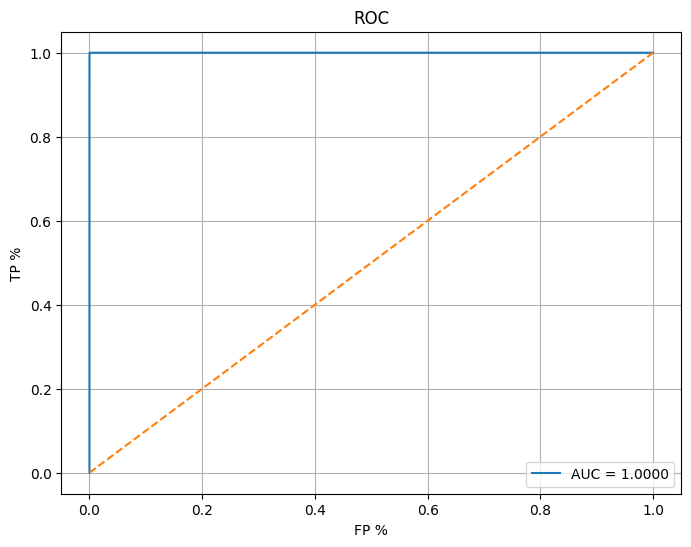

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve

y_prob = rf_classifier.predict_proba(x_test)[:, 1]  # prob for class 1 (positive)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("FP %")
plt.ylabel("TP %")
plt.title("ROC")
plt.legend()
plt.grid()
plt.show()

I also added a AUC/ROC graph just so it can help me to understand even better how FPR and TPR are moving alognside in a common graph.

So from the AUX/ROC graph above we can see that this is like an ideal scenario, since the model catches all the positives, and is not missclassifying a negative one. Clear depiction between class [0] and class [1].

# Step 4: Feature Importance (and selection)

In this step I will:

*  try to simpplify the model by using the most useful features
*  reduce the overfitting result by dropping noisy (or not so helpful with info columns)
*  finally, understand what is driving the decisions (features, columns, imoprtance, etc.)



 >>> [1] EXTRACTING THE TOP 15 MOST IMPORTANT FEATURES FROM THE RF CLASSIFIER ...


 Based on your extraction, the top 10 most important features are the following: 

int_rate                  0.696782
installment               0.041912
total_rec_int             0.036397
total_rec_prncp           0.029379
total_rev_hi_lim          0.018432
revol_util                0.016781
funded_amnt               0.012872
loan_amnt                 0.012381
dti                       0.011750
term_ 60 months           0.011312
revol_bal                 0.010734
annual_inc                0.010677
tot_cur_bal               0.010626
total_acc                 0.008087
mths_since_last_delinq    0.007512
dtype: float64


 >>> [2] CORRELATION MATRIX OF TOP 15 MOST IMPORTANT FEATURES ...


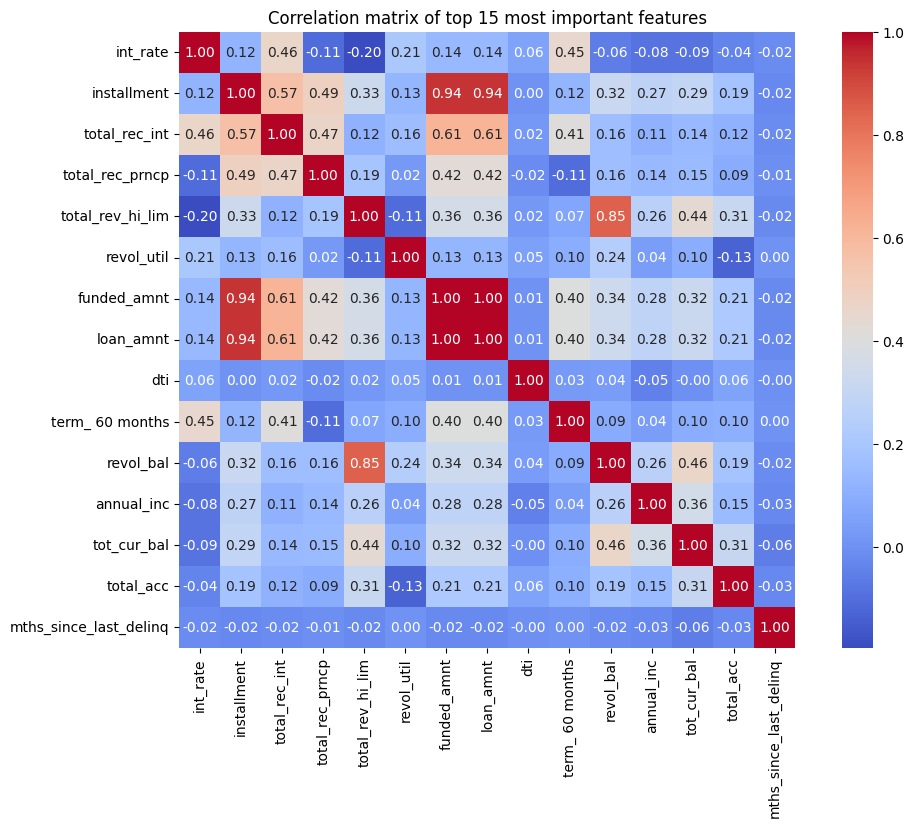

In [45]:
print("\n\n >>> [1] EXTRACTING THE TOP 15 MOST IMPORTANT FEATURES FROM THE RF CLASSIFIER ...")

importance = pd.Series(rf_classifier.feature_importances_, index=x_all.columns)
top_15_important_features = importance.sort_values(ascending=False).head(15)

print("\n\n Based on your extraction, the top 10 most important features are the following: \n")
print(top_15_important_features)


print("\n\n >>> [2] CORRELATION MATRIX OF TOP 15 MOST IMPORTANT FEATURES ...")

top_15_important_features_names = top_15_important_features.index.tolist()
correlation_matrix = x_all[top_15_important_features_names].corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation matrix of top 15 most important features")
plt.show()


Correlation Matrix explanation:
<br>

*  if it's 1, then we have a perfect correlation between those features
*  if it's 0, we don't have any correlation
*  of it's -1, then we have a perfect negative correlation, which means that those two features are one "against" the other (with a quick observation, I can see that the most negative correlation is at -0.20 and for few pairs of features, which is a good thing consindering that these are the top features of our model)



 >>> [3] SELECT LOW CORRELATED FEATURES ...


 The least correlated features are in total:  7


 and are the following:  ['mths_since_last_delinq', 'dti', 'revol_util', 'total_acc', 'annual_inc', 'term_ 60 months', 'int_rate']


 >>> [4] RETRAIN THE RF CLASSIFIER WITH THE NEW LEAST CORRELATED FEATURES SET ...


 The RF classifier has been retrained with the new low correlated features set


 >>> [5] EVALUATE THE RF CLASSIFIER'S RETRAINED RESULTS ...


 The RF Classification results: 
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000     56641
           1     0.9994    1.0000    0.9997      7259

    accuracy                         0.9999     63900
   macro avg     0.9997    1.0000    0.9998     63900
weighted avg     0.9999    0.9999    0.9999     63900



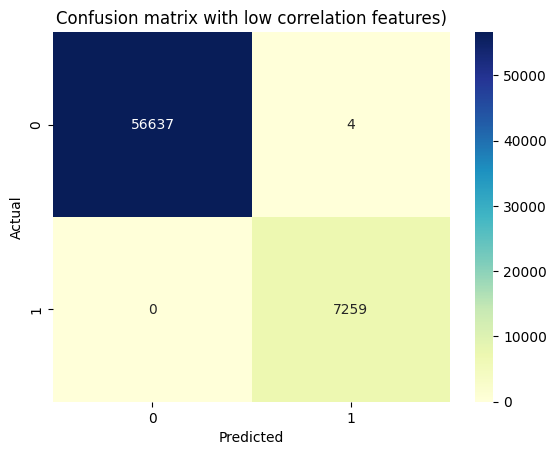

In [46]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("\n\n >>> [3] SELECT LOW CORRELATED FEATURES ...")

# ---- Finding the most uncorrelated features ----

# will get the absolute correlation matrix
abs_correlation_matrix = correlation_matrix.abs()

# ignore the diagonical (self-correlated) by adding 0, otherwise my logic won't work
np.fill_diagonal(abs_correlation_matrix.values, 0)

max_correlation_per_feature = abs_correlation_matrix.max()
sorted_features_by_max_value = max_correlation_per_feature.sort_values()

# chose 8 least correlated features (being half of the 15 total correlated features)
low_correlated_features = sorted_features_by_max_value.head(7).index.tolist()
print("\n\n The least correlated features are in total: ", len(low_correlated_features))
print("\n\n and are the following: ", low_correlated_features)

# ---- Finding the most uncorrelated features ----

print("\n\n >>> [4] RETRAIN THE RF CLASSIFIER WITH THE NEW LEAST CORRELATED FEATURES SET ...")

x_low_correlated_features = x_all[low_correlated_features]

x_train_low, x_test_low, y_train_low, y_test_low = train_test_split(
    x_low_correlated_features, y_target, test_size=0.3, random_state=42)

rf_classifier_low = RandomForestClassifier(random_state=42)
rf_classifier_low.fit(x_train_low, y_train_low)

print("\n\n The RF classifier has been retrained with the new low correlated features set")

print("\n\n >>> [5] EVALUATE THE RF CLASSIFIER'S RETRAINED RESULTS ...")

y_pred_low = rf_classifier_low.predict(x_test_low)

print("\n\n The RF Classification results: ")
print(classification_report(y_test_low, y_pred_low, digits=4))

cm_low = confusion_matrix(y_test_low, y_pred_low)
sns.heatmap(cm_low, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion matrix with low correlation features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In terms of metrics analysis we had (similarly to the previous matrix:

*   TP = 7259
*   TN = 56637
*   FP = 4

The model is again almost perfect (only 4 predictions missed out of 63.900 samples)

For class 1 recall is also 1.00 which means 100% success. That's the best result for any business.

Despite the fact that I used only 8 low correlated features from the total, the result kept its excellect predictive capabilities, which means that the features are really informative, corely needed and are pretty good for creating simple models onwards.

# Step 5: Dimensionality Reduction (PCA, LDA, UMAP)



 >>> [1] ENABLE SCALING TO PREPARE THE DATASET ACCORDINGLY ...


 >>> [2] APPLY PCA & TRAIN kNN CLASSIFIER ...
Accuracy for k=5 is: 0.9467619047619048
Accuracy for k=15 is: 0.938
Accuracy for k=51 is: 0.9198571428571428
Accuracy for k=101 is: 0.9074285714285715


 >>> [3] APPLY LDA & ENABLE 2D VISUALIZATION ...


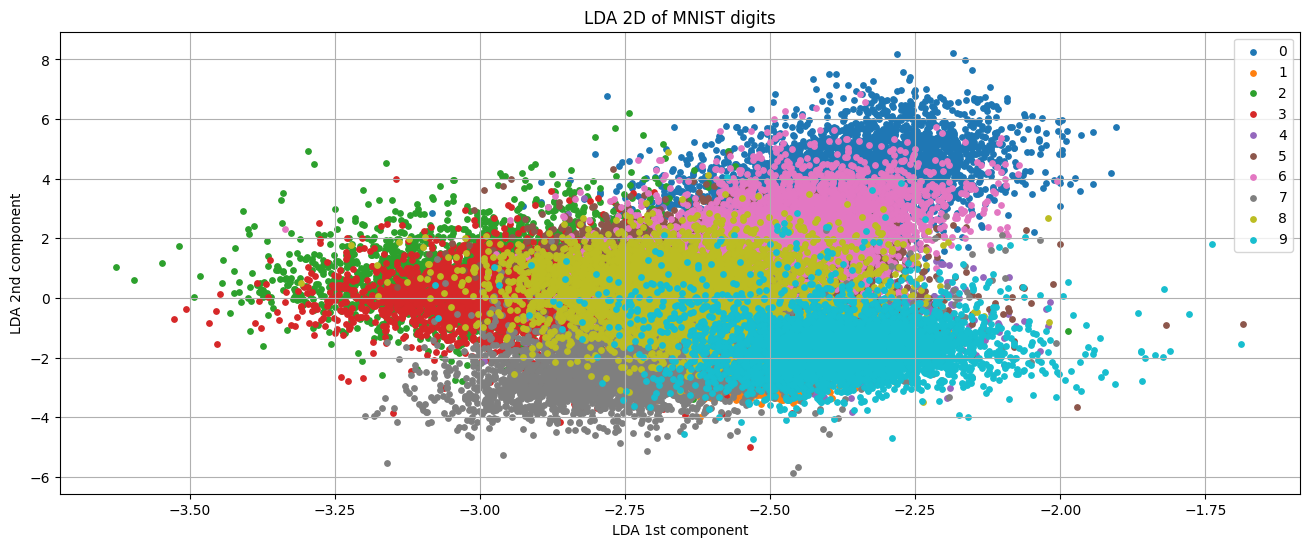



 >>> [4] APPLY UMAP & COMPARE WITH THE LDA RESULTS ...


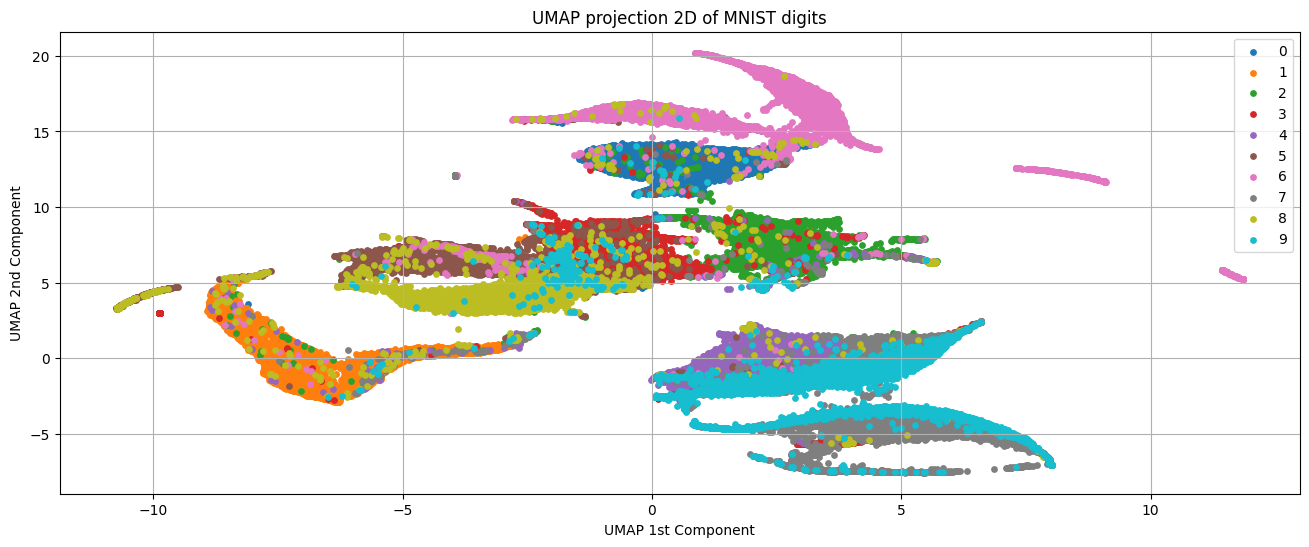

In [47]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

mnist = fetch_openml('mnist_784', version=1)

x = mnist.data.astype('float32')
y = mnist.target.astype('int64')

x.shape, y.shape

print("\n\n >>> [1] ENABLE SCALING TO PREPARE THE DATASET ACCORDINGLY ...")


# need to transform the images from 0-255 pixel range, to [0,1] so large numbers can't dominate
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

print("\n\n >>> [2] APPLY PCA & TRAIN kNN CLASSIFIER ...")

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42, stratify=y)

pca = PCA(n_components=300, random_state=42)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

k_values = [5, 15, 51, 101]
# the bigger the k the worst the accuracy (it's logical since the d [distance] is getting bigger)

for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(x_train_pca, y_train)
  y_pred = knn.predict(x_test_pca)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for k={k} is: {accuracy}")


print("\n\n >>> [3] APPLY LDA & ENABLE 2D VISUALIZATION ...")

lda_projection = LDA(n_components=2)
x_train_lda = lda_projection.fit_transform(x_train, y_train)
x_test_lda = lda_projection.transform(x_test)

plt.figure(figsize=(16, 6))
for label in np.unique(y_train):
    plt.scatter(x_train_lda[y_train == label, 0], x_train_lda[y_train == label, 1], label=str(label), s=15)

plt.title("LDA 2D of MNIST digits")
plt.xlabel("LDA 1st component")
plt.ylabel("LDA 2nd component")
plt.legend()
plt.grid()
plt.show()

print("\n\n >>> [4] APPLY UMAP & COMPARE WITH THE LDA RESULTS ...")

!pip install umap-learn --quiet

import umap

# was going too slow, so I searched in its docs, and mentioned that without random seed it's
# executed in parallel
umap_projetion = umap.UMAP(n_components=2)
x_umap = umap_projetion.fit_transform(x_scaled)

plt.figure(figsize=(16, 6))
for label in np.unique(y):
    plt.scatter(x_umap[y == label, 0], x_umap[y == label, 1], label=str(label), s=15)

plt.title("UMAP projection 2D of MNIST digits")
plt.xlabel("UMAP 1st Component")
plt.ylabel("UMAP 2nd Component")
plt.legend()
plt.grid()
plt.show()

**LDA 2D Observations**:

Generally I can see that some clusters are slighly separated such as 9, 3, 2 and 0 (almost at the edges of the visual)

5 and 1 are totally unvisible, which means that are overlapping a lot. In that case it seems that LDA didn't help a lot to separate these two clusters

There is a vast central hypercluser including parts from multiple clusters such as 8, 7, 6, 5, and 4. (some of them highly overlapping)

Overally, LDA seems to be helpful when it comes to linear separations, but is not fully capturing the separation of clusters in a more comlex nonlinaer structure.



**UMAP 2D Observations**:

Compared to the LDA, UMAP can capture nonlinear relationships of multiple clusters.

That's why we can see that clusters are clearly separated. Of course there are some samples with some overlapping, but generally the separation is clear and straightforward.

Especially compared to the LDA, UMAP is working way way better, improving the most overlapped clusters from the LDA projection such as 1, 5, and 4

My biggest surprise is about cluster 1 (orange) since under LDA didn't even exist due to overlapping, while here is clearly visible, even better compared to 3 (red) that under LDA dominated against the respective cluster (orange)